In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

In [2]:
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing import image
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [23]:
import pickle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Conv2D, MaxPool2D

In [4]:
import tensorflow
from sklearn.metrics import classification_report

In [9]:
import matplotlib.pyplot as plt
import itertools

In [10]:
metadata_labels = pd.read_csv('Mole_detection/csv_files/metadata_labels.csv')
metadata_labels.head()

,Unnamed: 0,image_id,dx
0,0,ISIC_0024306,4
1,1,ISIC_0024307,4
2,2,ISIC_0024308,4
3,3,ISIC_0024309,4
4,4,ISIC_0024310,6


In [7]:
metadata_labels.dx.value_counts()


4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: dx, dtype: int64

In [9]:
binary_csv = metadata_labels.copy()
binary_csv.dx = binary_csv.dx.replace([0, 1, 2, 3, 4, 5, 6], [1,1,0,0,0,0,1])

In [10]:
binary_csv.dx.value_counts()

0    8061
1    1954
Name: dx, dtype: int64

In [11]:
cancerous_csv = binary_csv[binary_csv.dx == 1]
cancerous_csv.reset_index(inplace=True)
cancer_list = cancerous_csv.image_id.to_list()


In [11]:
images_paths = ["Mole_detection/data/HAM10000_images_part_1/",
                "Mole_detection/data/HAM10000_images_part_2/"]
image_size = (224, 224)

In [12]:
def get_preprocessed_images_transfer_learning(images_directory: str, image_size: tuple) -> np.array:
    images = []
    for img in os.listdir(images_directory):
        img = image.load_img(images_directory+img, target_size=image_size)
        img = image.img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        images.append(img)
    return np.vstack(images)

In [13]:
images_array_lst = []
for path in images_paths:
    images_array = get_preprocessed_images_transfer_learning(path, image_size)
    images_array_lst.append(images_array)

In [11]:
# # binary 
# images_array_lst = []
# for path in images_paths:
#     images_array = get_preprocessed_images_transfer_learning(path, image_size)
#     images_array_lst.append(images_array)

In [14]:
skin_images = np.vstack(images_array_lst)

In [15]:
X = skin_images
target = metadata_labels.dx[:X.shape[0]]
# binary_target = binary_csv.dx[:X.shape[0]]

In [16]:
X.shape
binary_target.shape
binary_target[:6]

NameError: name 'binary_target' is not defined

In [18]:
df_tsne = pd.read_csv('Mole_detection/data/hmnist_28_28_RGB.csv')
X_tsne = df_tsne.drop('label', axis=1)

NameError: name 'sns' is not defined

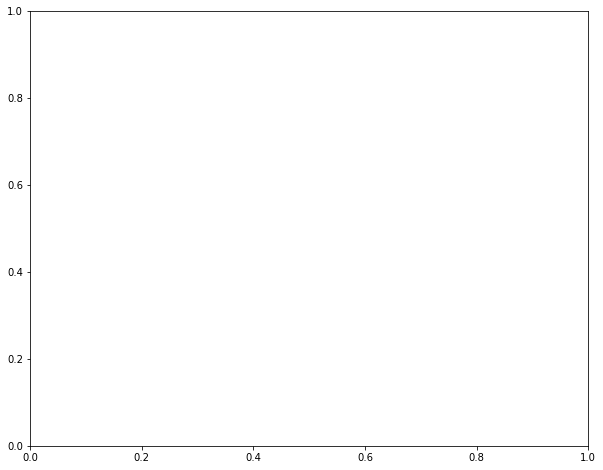

In [19]:
from sklearn.manifold import TSNE

X_copy = X_tsne.copy()

p = 15
model = TSNE(perplexity=p, random_state=42)
tsne_features = model.fit_transform(X_tsne)
X_copy['x'] = tsne_features[:, 0]
X_copy['y'] = tsne_features[:, 1]
X_copy['target'] = target

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='target', data=X_copy, alpha=0.8)
plt.legend(bbox_to_anchor=[-0.15, 0.5], loc='center left')
plt.title('perplexity ' + str(p))
plt.xticks([])
plt.yticks([])
plt.show()

In [17]:
target_one_hot = tf.keras.utils.to_categorical(target, num_classes=7, dtype="int")
# binary_target_one_hot = tf.keras.utils.to_categorical(binary_target, num_classes=7, dtype="int")

In [18]:
def split_in_train_val_test(X, target):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X,
        target,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    return X_train, X_val, y_train, y_val, X_test, y_test

In [19]:
# multiclass
X_train, X_val, y_train, y_val, X_test, y_test = split_in_train_val_test(X, target_one_hot)

In [38]:
#binary
X_train, X_val, y_train, y_val, X_test, y_test = split_in_train_val_test(X, binary_target)

In [21]:
def instantiate_model_v3_mobilenet(X_train, X_val, y_train, y_val):
    model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in model.layers:
        layer.trainable = False

    new_model = Sequential()
    new_model.add(model)
#     new_model.add(Conv2D(32, activation='relu'))
    new_model.add(Dropout(0.5))
#     new_model.add(BatchNormalization())
    new_model.add(Flatten())
    new_model.add(Dropout(0.5))
    new_model.add(Dense(64, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(7, activation='softmax'))

    new_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy']
                     )

    history = new_model.fit(X_train, y_train,
                            epochs=30,
                            batch_size=64,
                            validation_data=(X_val, y_val)
                            )

    new_model.save('v3_mobilenetv2_binary.h5')
    with open('v3_history', 'wb') as filepath:
        pickle.dump(history.history, filepath)

    return history.history, new_model

In [26]:
history_hist, model = instantiate_model_v3_mobilenet(X_train, X_val, y_train, y_val)

Epoch 1/30
101/101 [==============================] - 20s 164ms/step - loss: 0.5152 - accuracy: 0.6502 - val_loss: 0.2578 - val_accuracy: 0.6887
Epoch 2/30
101/101 [==============================] - 15s 152ms/step - loss: 0.3424 - accuracy: 0.6756 - val_loss: 0.2091 - val_accuracy: 0.6937
Epoch 3/30
101/101 [==============================] - 16s 154ms/step - loss: 0.3095 - accuracy: 0.6767 - val_loss: 0.2032 - val_accuracy: 0.6843
Epoch 4/30
101/101 [==============================] - 16s 154ms/step - loss: 0.2767 - accuracy: 0.6795 - val_loss: 0.1991 - val_accuracy: 0.6781
Epoch 5/30
101/101 [==============================] - 15s 152ms/step - loss: 0.2610 - accuracy: 0.6762 - val_loss: 0.1864 - val_accuracy: 0.7087
Epoch 6/30
101/101 [==============================] - 16s 155ms/step - loss: 0.2481 - accuracy: 0.6834 - val_loss: 0.1937 - val_accuracy: 0.6974
Epoch 7/30
101/101 [==============================] - 16s 154ms/step - loss: 0.2386 - accuracy: 0.6840 - val_loss: 0.1850 - val_ac

C:\Users\maart\miniconda3\envs\mole_challenge\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [40]:
import tensorflow
def plot_history(history: tensorflow.keras.callbacks.History):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].plot(history['accuracy'], label='training set')
    axs[0].plot(history['val_accuracy'], label='validation set')
    axs[0].set(xlabel='Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history['loss'], label='training set')
    axs[1].plot(history['val_loss'], label='validation set')
    axs[1].set(xlabel='Epoch', ylabel='Loss', ylim=[0, 3])

    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')
    plt.savefig('plot_history_multiclass.png')
    plt.show()

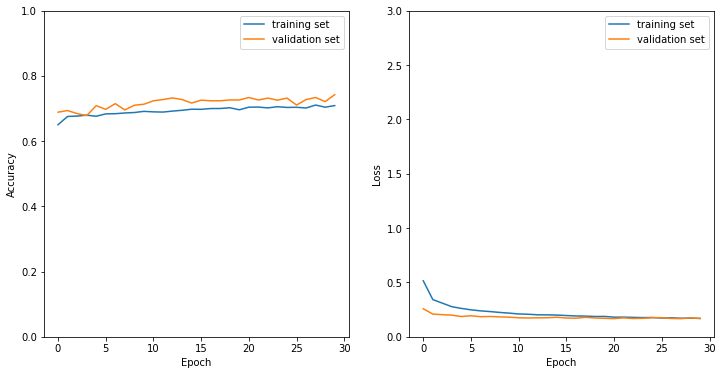

In [41]:
plot_history(history_hist)

In [25]:
# invert one hot encoding
y_test_one_column = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

In [45]:
# binary 
y_pred = np.argmax(model.predict(X_test), axis=1)

In [26]:
y_pred

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [50]:
def print_binary_accuracy_classificationreport_confusionmmatrix(y_pred,
                                                         model, X_test, y_test):
    results = model.evaluate(X_test, y_test, batch_size=20)
    print(f"Accuracy on test set is {results[1] * 100:.2f}%")
    print(classification_report(y_test, y_pred))
    print(tensorflow.math.confusion_matrix(y_test, y_pred))
print_binary_accuracy_classificationreport_confusionmmatrix(y_pred,
                                                         model, X_test, y_test)

101/101 [==============================] - 4s 39ms/step - loss: 0.3669 - accuracy: 0.7968
Accuracy on test set is 79.68%
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1596
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2003
   macro avg       0.40      0.50      0.44      2003
weighted avg       0.63      0.80      0.71      2003

tf.Tensor(
[[1596    0]
 [ 407    0]], shape=(2, 2), dtype=int32)


C:\Users\maart\miniconda3\envs\mole_challenge\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maart\miniconda3\envs\mole_challenge\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maart\miniconda3\envs\mole_challenge\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [ ]:
def print_accuracy_classificationreport_confusionmmatrix(y_test_one_column, y_pred,
                                                         model, X_test, y_test):
    results = model.evaluate(X_test, y_test, batch_size=20)
    print(f"Accuracy on test set is {results[1] * 100:.2f}%")
    print(classification_report(y_test_one_column, y_pred))
    print(tensorflow.math.confusion_matrix(y_test_one_column, y_pred))

In [ ]:
print_accuracy_classificationreport_confusionmmatrix(y_test_one_column,
                                                y_pred, model, X_test, y_test)

In [27]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues, figsize=(10,10)):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    cm = np.round(cm, 2) * 100
    print(cm)
    thresh = cm.max() / 2.
    
    fig, ax = plt.subplots(figsize=(7,7))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    name_path = 'confusion_matrix_multiclass.jpg'
    plt.savefig(name_path)
    plt.show()

Normalized confusion matrix
[[  0.   0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.   0.]]


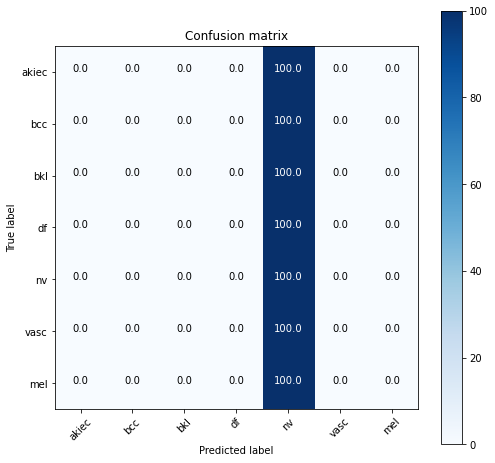

In [28]:
cm = confusion_matrix(y_test_one_column, y_pred)
classes = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
plot_confusion_matrix(cm, classes, normalize=True)